In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from DataScraper import DataScraper

In [ ]:
apikey = None # Your API key here

In [2]:
filename = "uniswapBinance.csv"

df = pd.read_csv(filename)
average = round(df["reserveUSD"].mean(), 2)
print(f"Average total value locked: ${average}")
df["price"] = df["reserve1"] / df["reserve0"]
df = df.round(3)

Average total value locked: $7791894.41


In [3]:
class DexSwap:
    def __init__(self, token1_pool: float, token2_pool: float, token_address: str, symbol1: str, symbol2: str):
        self.token1_pool = token1_pool
        self.token2_pool = token2_pool
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.token_address = token_address  # Simulated as a string since we can't interact with actual ERC20 contracts here

    def token_swap(self, msg_value: float, includeFee: False) -> float:
        # # Calculate fee (0.15% of the transaction)
        fee = msg_value * 0.0015

        # Calculate invariant (k)
        invariant = self.token1_pool * self.token2_pool

        # Calculate new pool (token0) size
        new_token1_pool = self.token1_pool + msg_value

        # Calculate new token pool size to maintain the invariant (k)
        if includeFee:
            new_token2_pool = invariant / (new_token1_pool - fee)
        else:
            new_token2_pool = invariant / new_token1_pool

        # Calculate tokens out
        tokens_out = self.token2_pool - new_token2_pool

        # Update the pools
        self.token1_pool = new_token1_pool
        self.token2_pool = new_token2_pool

        #print(f"Swap: {msg_value} {self.symbol1} for {tokens_out} {self.symbol2}")

        return tokens_out 
    
    def calculatePoolState(self, cexPrice: float, plots: bool, info: bool) -> tuple:
            
            if info:
                print(f"Initial state: {self.token1_pool} {self.symbol1} and {self.token2_pool} {self.symbol2}")
        
            initial_price = self.token2_pool / self.token1_pool

            if info:
                print(f"Initial DEX price: {initial_price} {self.symbol2}/{self.symbol1}")
                print(f"Initial CEX price: {cexPrice} {self.symbol2}/{self.symbol1}\n")
            
            # Simulate small transactions
            msg_value = self.token1_pool / 1000000
            if info:
                print(f"Using a txn value of: {msg_value} {self.symbol1}\n")
            
            total_token1_injected = 0  # Keep track of total token0 amount injected
            total_token2_output = 0  # Keep track of total token1 amount output

            new_price = initial_price
            prices = []
            input_amounts = []
            output_amounts = []
            profit = []
            while True:
                prices.append(new_price)
                input_amounts.append(msg_value)
                # Add in a small amount of token 1 to the pool
                tokens_out = self.token_swap(msg_value, includeFee = False)
                output_amounts.append(tokens_out)
                
                profit.append(tokens_out - msg_value*cexPrice) 

                # Increment the total amounts injected and output
                total_token1_injected += msg_value
                total_token2_output += tokens_out

                # Calculate new price
                new_price = self.token2_pool / self.token1_pool
                #print(new_price, cexPrice, abs(new_price - cexPrice))
                
                #Check if the new price is close to the CEX price
                if new_price < cexPrice:
                    break

                # This is for extending the chart so that we can see when the profit starts decreasing
                # if np.cumsum(input_amounts)[-1] > 110:
                #      break
            
            if plots:
                # Plot the price curve
                plt.plot(np.cumsum(input_amounts), prices, label = "Pool Price")
                plt.axhline(y = cexPrice, label='CEX Price', color='red')
                plt.legend()
                plt.xlabel('Tokens injected (cumulative)')
                plt.ylabel('Price')
                plt.title('Price Curve')

                plt.show()

                # Plot the input and output amounts
                plt.plot(input_amounts, label='Input Amounts')
                plt.plot(output_amounts, label='Output Amounts')
                plt.xlabel('Transactions')
                plt.ylabel('Amount')
                plt.title('Input and Output Amounts')
                plt.legend()
                plt.show()

                print("First output:", output_amounts[0])
                print("Last output:", output_amounts[-1])

                # Plot the profit curve
                plt.plot(np.cumsum(input_amounts), np.cumsum(profit), label = "Profit (without fees)")
                plt.legend()
                plt.xlabel('Tokens injected (cumulative)')
                plt.ylabel('Profit')
                plt.title('Profit Curve')
                plt.show()

                print("Total profit:", np.cumsum(profit)[-1])
                print("Total tokens injected:", total_token1_injected)
                print("Total tokens output:", total_token2_output)
                
            if info:
                # Calculate the average price of token0 in terms of token1
                average_price = total_token2_output / total_token1_injected

                print(f"Final state: {self.token1_pool} {self.symbol1} and {self.token2_pool} {self.symbol2}")
                print(f"Final DEX price: {self.token2_pool / self.token1_pool}")
                print(f"Final CEX price: {cexPrice}")
                print(f"Total {self.symbol1} injected: {total_token1_injected}")
                print(f"Total {self.symbol2} output: {total_token2_output}")
                print(f"Average price: {average_price} {self.symbol2}/{self.symbol1}")

                # Return the final state and the average price, all values truncated to 3 decimal places
                return round(np.cumsum(profit)[-1]), round(self.token2_pool, 3), round(self.token1_pool, 3), round(new_price, 3), round(average_price, 3), round(total_token1_injected, 3)

            
            # Return the final state and the average price, all values truncated to 3 decimal places
            return round(np.cumsum(profit)[-1]), round(self.token2_pool, 3), round(self.token1_pool, 3), round(new_price, 3), round(total_token1_injected, 3)

#### Testing

WETH/USDT

In [4]:
res = {}
test1 = DexSwap(19286, 66261837, "0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852", "WETH", "USDT")
res["WETH/USDT"] = test1.token_swap(10, includeFee = False)

MKR/DAI

In [5]:
test2 = DexSwap(21997.23, 73810107.627, "0x517F9dD285e75b599234F7221227339478d0FcC8", "MKR", "DAI")
res["MKR/DAI"] = test2.token_swap(10, includeFee = False)

WETH/USDC

In [6]:
test3  = DexSwap(13329, 45752470, "0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc", "WETH", "USDC")
res["WETH/USDC"] = test3.token_swap(10, includeFee = False)
print(res["WETH/USDC"])

34299.77509558201


PEPE/WETH

In [7]:
test4 = DexSwap(5222.6, 2650852827023, "0xA43fe16908251ee70EF74718545e4FE6C5cCEc9f", "WETH", "PEPE")
res["WETH/PEPE"] = test4.token_swap(10, includeFee = False)
print(res["WETH/PEPE"])

5066033763.374023


DAI/WETH

In [8]:
test5 = DexSwap(2214.56, 7581066.275, "0xA478c2975Ab1Ea89e8196811F51A7B7Ade33eB11", "WETH", "DAI")
res["WETH/DAI"] = test5.token_swap(10, includeFee = False)

[34339.675062187016, 33539.02677756548, 34299.77509558201, 5066033763.374023, 34078.94718506094]
[0.27997787099274346, 0.39731061974979676, 0.581426317264661, 0.2515922873283987, 0.025677340914923588]


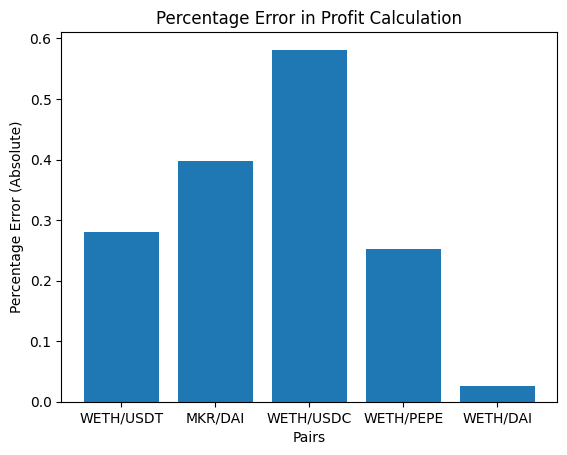

0.3071968872501047


In [9]:
modelResults = list(res.values())
print(modelResults)
results = [34243.8, 33406.3, 34101.5, 5053320000, 34087.7]
diff = list(map(lambda x, y: abs(x-y), modelResults, results))
diff = list(map(lambda x, y: x/y*100, diff, results))
print(diff)
plt.bar(["WETH/USDT", "MKR/DAI", "WETH/USDC", "WETH/PEPE", "WETH/DAI"], diff)
plt.xlabel("Pairs")
plt.ylabel("Percentage Error (Absolute)")
plt.title("Percentage Error in Profit Calculation")
plt.show()

print(np.mean(diff))


#### Conti.

In [10]:
test = df.iloc[0]
test

id            0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852
reserve0                                       17386.744
reserve1                                    62320425.173
reserveUSD                                 124710546.373
token0        0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
token1        0xdac17f958d2ee523a2206206994597c13d831ec7
symbol1                                             WETH
symbol2                                             USDT
price                                           3584.364
Name: 0, dtype: object

Initial state: 17386.744 WETH and 62320425.173 USDT
Initial DEX price: 3584.3643394645947 USDT/WETH
Initial CEX price: 3548.52036 USDT/WETH

Using a txn value of: 0.017386744 WETH



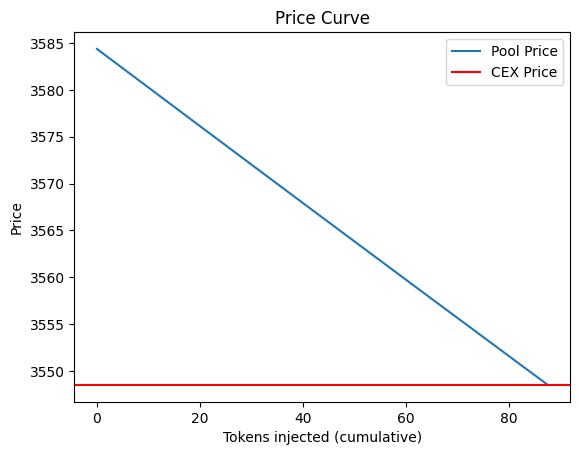

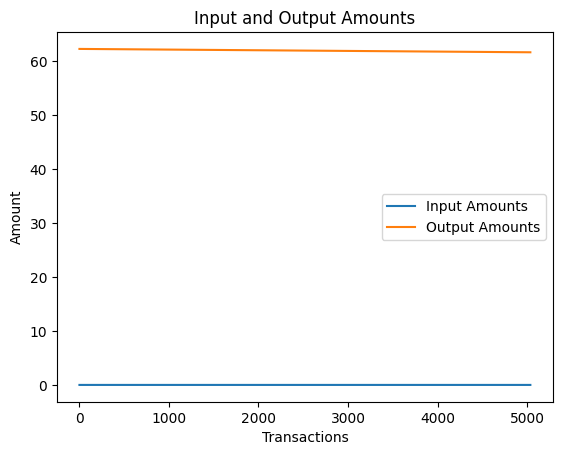

First output: 62.32036284357309
Last output: 61.69725961983204


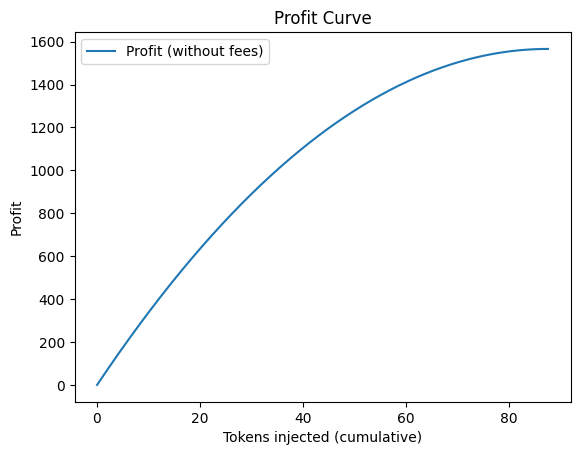

Total profit: 1565.8791305804127
Total tokens injected: 87.59441627200749
Total tokens output: 312396.44869408756
Final state: 17474.338416266663 WETH and 62008028.72430591 USDT
Final DEX price: 3548.51939153149
Final CEX price: 3548.52036
Total WETH injected: 87.59441627200749
Total USDT output: 312396.44869408756
Average price: 3566.3968320081144 USDT/WETH


In [11]:
pool = DexSwap(test["reserve0"], test["reserve1"], test["id"], test["symbol1"], test["symbol2"])
initial_price = test["price"]
cexPrice = test["price"] * 0.99

profit, final_token2_pool, final_token1_pool, new_price, average_price, total_token1_injected = pool.calculatePoolState(cexPrice, True, True)

Now we do the above but in one transaction:

In [12]:
def simulateArbitrage():
    pool = DexSwap(test["reserve0"], test["reserve1"], test["id"], test["symbol1"], test["symbol2"])
    output = pool.token_swap(total_token1_injected, includeFee=True)
    profit = output - total_token1_injected*cexPrice
    gasFees = DataScraper(apikey).getSwapPrice()
    profit = profit - gasFees
    txnFees = DataScraper(apikey).getTxnPrice()
    profit = profit - txnFees
    print(f"Input: {total_token1_injected} {pool.symbol1}")
    print(f"Output: {output} {pool.symbol2}")
    print(f"Profit (with fee): {profit} {pool.symbol2}")
    print(f"Final state: {pool.token1_pool} {pool.symbol1} and {pool.token2_pool} {pool.symbol2}")

simulateArbitrage()

Gas Price: 11.0
Eth Price: 3119.97
Swap Price: 12.2243232573 USD
Gas Price: 11.0
Eth Price: 3119.97
Txn Price: 0.7207130700000001 USD
Input: 87.594 WETH
Output: 311928.7245243266 USDT
Profit (with fee): 1086.692110486622 USDT
Final state: 17474.338 WETH and 62008496.448475674 USDT


Gas Price: 11.0
Eth Price: 3119.97
Swap Price: 12.2243232573 USD
Gas Price: 11.0
Eth Price: 3119.97
Txn Price: 0.7207130700000001 USD
0.997


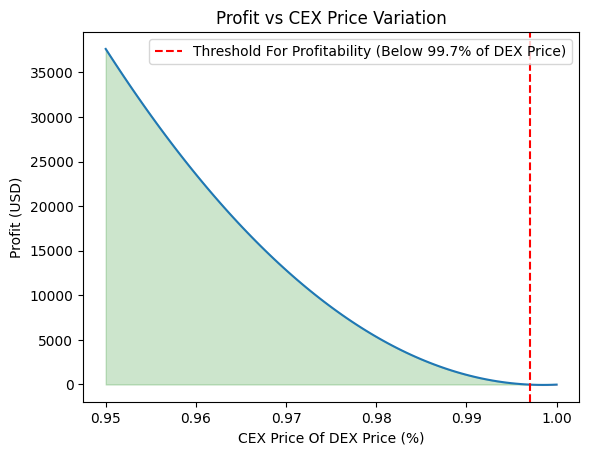

y = 16198177.78x^2 + -32337403.50x + 16139262.64


In [13]:
def runWithPriceVariations():
    variations = np.linspace(0.95, 1, 100)
    profits = []
    scraper = DataScraper(apikey) 
    gasFees = scraper.getSwapPrice()
    txnFees = scraper.getTxnPrice()

    for x in variations:
        pool = DexSwap(test["reserve0"], test["reserve1"], test["id"], test["symbol1"], test["symbol2"])
        initial_price = test["price"]
        cexPrice = test["price"] * x

        profit, final_token2_pool, final_token1_pool, new_price, total_token1_injected = pool.calculatePoolState(cexPrice, plots = False, info = False)

        # Perform the arbitrage in one transaction
        pool = DexSwap(test["reserve0"], test["reserve1"], test["id"], test["symbol1"], test["symbol2"])
        output = pool.token_swap(total_token1_injected, includeFee=True)
        profit = output - total_token1_injected*cexPrice
        profit = profit - gasFees
        profit = profit - txnFees

        profits.append(profit)

        # print(f"Input: {total_token1_injected} {pool.symbol1}")
        # print(f"Output: {output} {pool.symbol2}")
        # print(f"Profit (with fee): {profit} {pool.symbol2}")
        # print(f"Final state: {pool.token1_pool} {pool.symbol1} and {pool.token2_pool} {pool.symbol2}")

    threshold = round(variations[np.where(np.array(profits) < 0)][0],3)
    print(threshold)

    plt.plot(variations, profits)
    # Fill the area left of the threshold
    plt.fill_between(variations, profits, where=(variations < threshold), color='green', alpha=0.2, interpolate=True)
    # Fill the area right of the threshold
    plt.fill_between(variations, profits, where=(variations >= threshold), color='red', alpha=0.2, interpolate=True)

    plt.axvline(threshold, label=f'Threshold For Profitability (Below {threshold*100}% of DEX Price)', color='red', linestyle = "--")
    plt.xlabel('CEX Price Of DEX Price (%)')
    plt.ylabel('Profit (USD)')
    plt.title('Profit vs CEX Price Variation')
    plt.legend()
    plt.show()

    coefs = np.polyfit(variations, profits, 2)
    poly_eq = np.polynomial.Polynomial(coefs[::-1])
    equation = f"y = {poly_eq.coef[2]:.2f}x^2 + {poly_eq.coef[1]:.2f}x + {poly_eq.coef[0]:.2f}"
    print(equation)
    

runWithPriceVariations()

    

Model is built for descending the pool price (therefore we will only work with price variations in the negatives)